In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

In [6]:
flows = pd.read_csv("../data/inflows of foreign population by nationality.csv", low_memory=False)

flows = flows.dropna(subset=['Value'])
flows_cleaned = flows.dropna(subset=['Value'])

# dropping columns that we don't need
flows_cleaned = flows.drop(columns=['Flag Codes', 'Flags'])

In [7]:
inflows_cleaned = flows_cleaned[flows_cleaned['Variable'] == 'Inflows of foreign population by nationality']
inflows_cleaned = inflows_cleaned[inflows_cleaned['Country of birth/nationality'] == "Total"]

In [8]:
df = inflows_cleaned[['Country of birth/nationality', 'Country', 'Year', 'Value']]

In [9]:
df.head()

,Country of birth/nationality,Country,Year,Value
190304,Total,Australia,2000,107148.0
190305,Total,Australia,2001,127877.0
190306,Total,Australia,2002,119080.0
190307,Total,Australia,2003,123411.0
190308,Total,Australia,2004,146441.0


In [11]:
df.shape

(739, 4)

In [36]:
df_USA = df[df['Country'] == 'United States']
df_USA_cleaned = df_USA[['Year', 'Value']]
df_USA_cleaned['Year']=pd.to_datetime(df_USA_cleaned['Year'], format= '%Y')
df_USA_cleaned.set_index('Year', inplace= True)

In [37]:
df_USA_cleaned.head()

,Value
Year,
2000-01-01,841002.0
2001-01-01,1058902.0
2002-01-01,1059356.0
2003-01-01,703542.0
2004-01-01,957883.0


# Implementing ARIMA in USA immigration inflows

In [14]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

Text(0, 0.5, 'Population per Year')

<Figure size 1400x400 with 0 Axes>

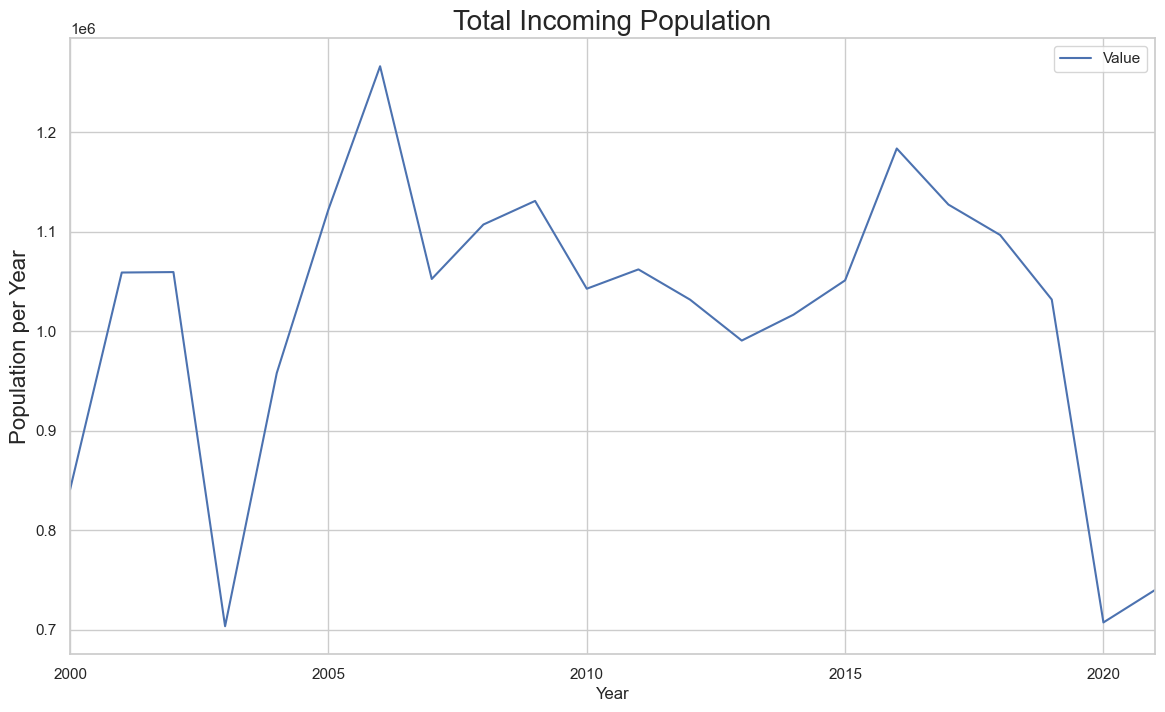

In [38]:

#plot
plt.figure(figsize=(14,4))
df_USA_cleaned.plot()
plt.title('Total Incoming Population', fontsize=20)
plt.ylabel('Population per Year', fontsize=16)

In [40]:
# Testing for stationary 
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df_USA_cleaned['Value'])

In [41]:
#HYPOTHESIS TEST:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    
    result=adfuller(sales)
    
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [42]:
adfuller_test(df_USA_cleaned['Value'])

ADF Test Statistic : -2.8658410682118305
p-value : 0.0494668532634015
#Lags Used : 3
Number of Observations Used : 18
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


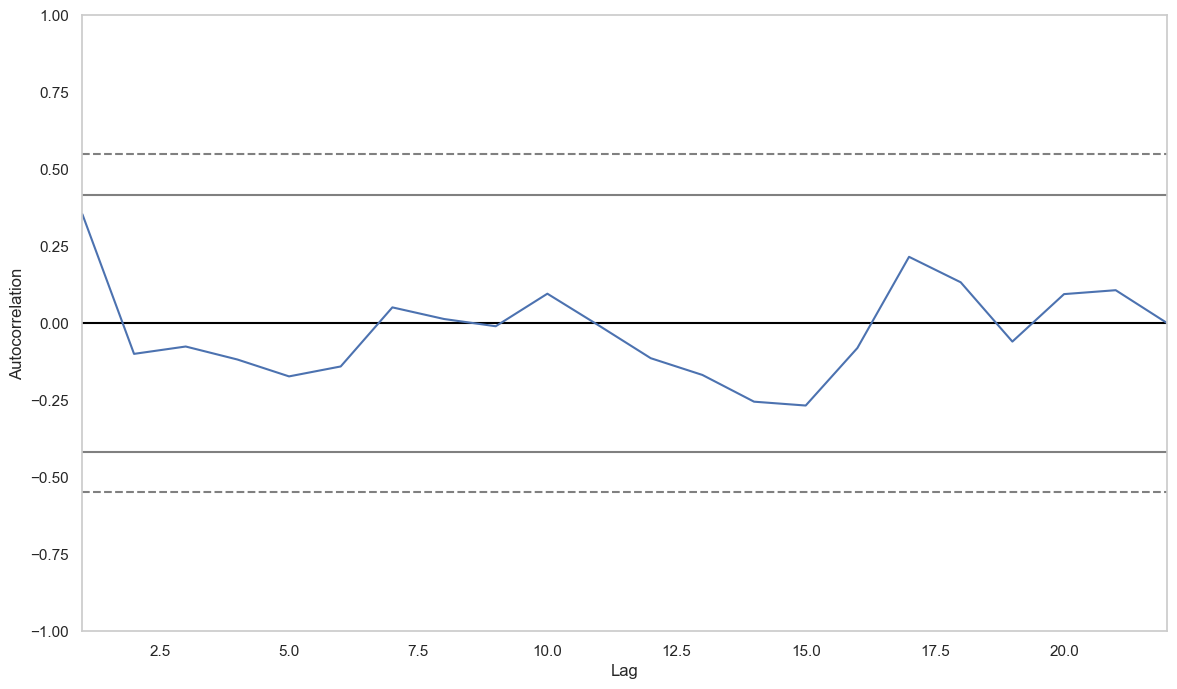

In [43]:
# looking for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_USA_cleaned['Value'])
plt.show()

In [46]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_USA_cleaned['Value'], order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   22
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -281.207
Date:                Sun, 21 Apr 2024   AIC                            568.414
Time:                        18:09:41   BIC                            571.547
Sample:                    01-01-2000   HQIC                           569.094
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0407      1.685     -0.024      0.981      -3.343       3.262
ma.L1          0.1557      1.689      0.092      0.927      -3.154       3.465
sigma2      1.401e+10   2.52e-10   5.56e+19      0.0

<Axes: xlabel='Year'>

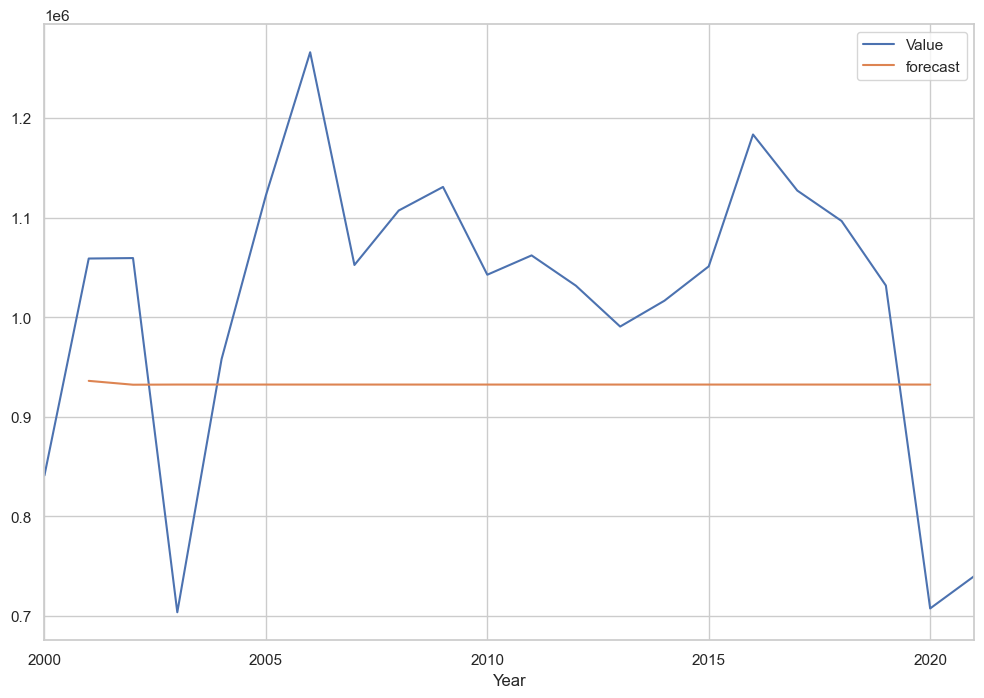

In [48]:
df_USA_cleaned['forecast']=model_fit.predict(start=1,end=20,dynamic=True)
df_USA_cleaned[['Value','forecast']].plot(figsize=(12,8))

# Implementing SARIMA

In [55]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_USA_cleaned['Value'],order=(1,1 , 1),seasonal_order=(1,1,1,12))
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67916D+00    |proj g|=  3.91241D-01

At iterate    5    f=  5.48372D+00    |proj g|=  2.50162D-02

At iterate   10    f=  5.47335D+00    |proj g|=  1.84953D-03

At iterate   15    f=  5.47118D+00    |proj g|=  3.91405D-03

At iterate   20    f=  5.47078D+00    |proj g|=  6.33631D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   9.301D-06   5.471D+00
  F =   5.4707780097510117     

CONVERG

 This problem is unconstrained.


<Axes: xlabel='Year'>

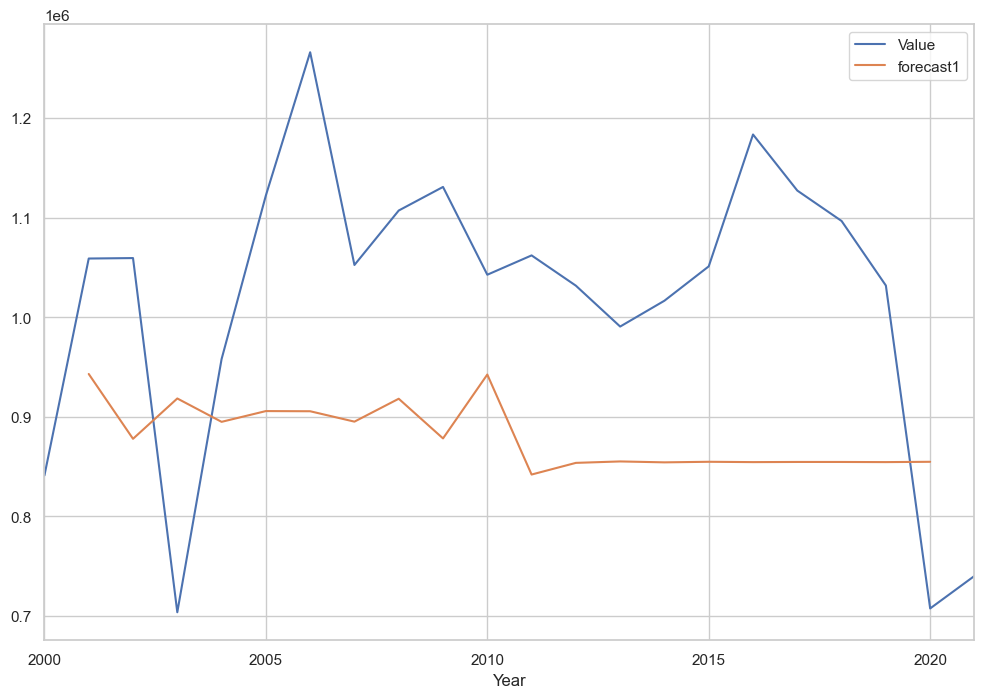

In [56]:
# forecasting
df_USA_cleaned['forecast1']=results.predict(start=1,end=20,dynamic=True)
df_USA_cleaned[['Value','forecast1']].plot(figsize=(12,8))

In [57]:
# Predict for future
from pandas.tseries.offsets import DateOffset


last_year = df_USA_cleaned.index[-1].year
future_dates = [pd.to_datetime(last_year + x, format='%Y') for x in range(1, 25)]

In [62]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_USA_cleaned.columns)

In [64]:
future_df=pd.concat([df_USA_cleaned,future_datest_df])

<Axes: >

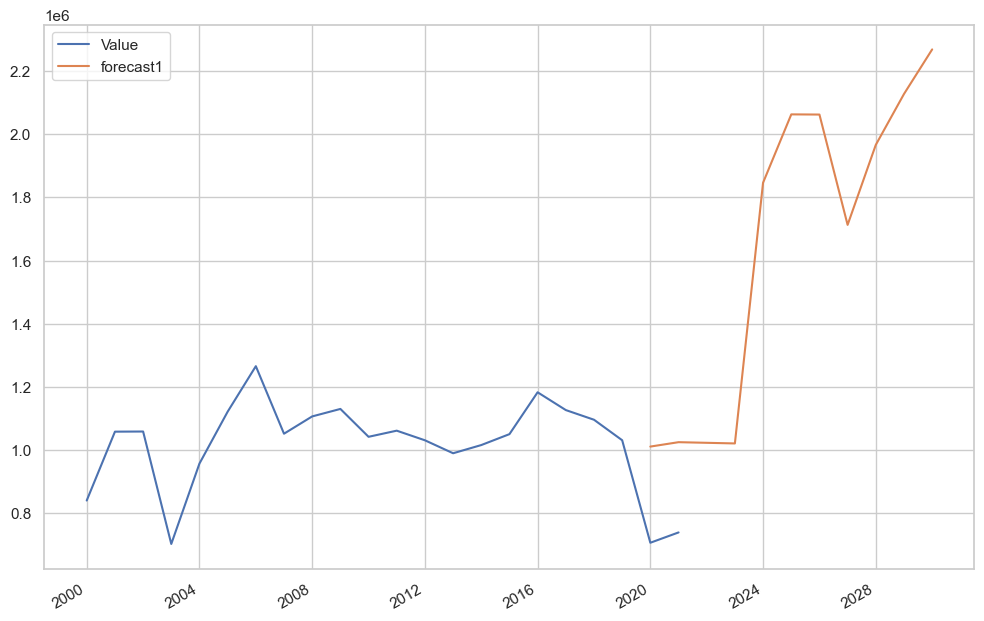

In [70]:
future_df['forecast1'] = results.predict(start = 20, end = 30, dynamic= True)  
future_df[['Value', 'forecast1']].plot(figsize=(12, 8))

Source: https://www.kaggle.com/code/harshjain123/time-series-arima-sarima